Define Each Technical Strategy '\n'
We will create classes for each technical strategy: Moving Average Crossover, RSI, Bollinger Bands, MACD, and EMA Crossover.

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Data Download Function
def download_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

# 2. Moving Average Crossover Strategy
class MovingAverageCrossoverStrategy:
    def __init__(self, short_window=50, long_window=200):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, data):
        data['Short_MA'] = data['Close'].rolling(window=self.short_window).mean()
        data['Long_MA'] = data['Close'].rolling(window=self.long_window).mean()
        data['Signal'] = 0
        data.loc[data.index[self.short_window:], 'Signal'] = np.where(
            data['Short_MA'].iloc[self.short_window:] > data['Long_MA'].iloc[self.short_window:], 1, 0)
        data['Position'] = data['Signal'].diff()
        return data

# 3. RSI Strategy
class RSIStrategy:
    def __init__(self, period=14, rsi_overbought=70, rsi_oversold=30, ma_window=50):
        self.period = period
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold
        self.ma_window = ma_window

    def generate_signals(self, data):
        delta = data['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=self.period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.period).mean()
        rs = gain / loss
        data['RSI'] = 100 - (100 / (1 + rs))
        
        data['MA'] = data['Close'].rolling(window=self.ma_window).mean()
        data['Signal'] = 0
        data['Signal'] = np.where(
            (data['RSI'] < self.rsi_oversold) & (data['Close'] > data['MA']), 1,
            np.where((data['RSI'] > self.rsi_overbought) & (data['Close'] < data['MA']), -1, 0)
        )
        data['Position'] = data['Signal'].diff()
        return data


# 4. Bollinger Bands Strategy
class BollingerBandsStrategy:
    def __init__(self, window=20, no_of_std=2):
        self.window = window
        self.no_of_std = no_of_std

    def generate_signals(self, data):
        data['Middle_Band'] = data['Close'].rolling(window=self.window).mean()
        data['Upper_Band'] = data['Middle_Band'] + (data['Close'].rolling(window=self.window).std() * self.no_of_std)
        data['Lower_Band'] = data['Middle_Band'] - (data['Close'].rolling(window=self.window).std() * self.no_of_std)
        
        data['Signal'] = 0
        data['Signal'] = np.where(
            (data['Close'] < data['Lower_Band']) & (data['Close'].shift(1) >= data['Lower_Band'].shift(1)), 1, 
            np.where(
                (data['Close'] > data['Upper_Band']) & (data['Close'].shift(1) <= data['Upper_Band'].shift(1)), -1, 0
            )
        )
        data['Position'] = data['Signal'].diff()
        return data


# 5. MACD Strategy
class MACDStrategy:
    def __init__(self, short_window=12, long_window=26, signal_window=9):
        self.short_window = short_window
        self.long_window = long_window
        self.signal_window = signal_window

    def generate_signals(self, data):
        data['MACD'] = data['Close'].ewm(span=self.short_window, min_periods=1, adjust=False).mean() - data['Close'].ewm(span=self.long_window, min_periods=1, adjust=False).mean()
        data['Signal_Line'] = data['MACD'].ewm(span=self.signal_window, min_periods=1, adjust=False).mean()
        data['Signal'] = 0
        data['Signal'] = np.where(data['MACD'] > data['Signal_Line'], 1, np.where(data['MACD'] < data['Signal_Line'], -1, 0))
        data['Position'] = data['Signal'].diff()
        return data

# 6. Exponential Moving Average Crossover Strategy
class EMACrossoverStrategy:
    def __init__(self, short_window=12, long_window=26):
        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self, data):
        data['Short_EMA'] = data['Close'].ewm(span=self.short_window, adjust=False).mean()
        data['Long_EMA'] = data['Close'].ewm(span=self.long_window, adjust=False).mean()
        data['Signal'] = 0
        data['Signal'] = np.where(data['Short_EMA'] > data['Long_EMA'], 1, np.where(data['Short_EMA'] < data['Long_EMA'], -1, 0))
        data['Position'] = data['Signal'].diff()
        return data


2. Backtesting Class
The backtesting class evaluates each strategy and tracks the portfolio value over time.

In [6]:
class Backtester:
    def __init__(self, initial_capital=10000.0):
        self.initial_capital = initial_capital

    def run_backtest(self, data):
        cash = self.initial_capital
        shares_held = 0
        portfolio_value = []

        for i in range(len(data)):
            if data['Position'].iloc[i] == 1:  # Buy signal
                shares_held = cash // data['Close'].iloc[i]
                cash -= shares_held * data['Close'].iloc[i]
            elif data['Position'].iloc[i] == -1:  # Sell signal
                cash += shares_held * data['Close'].iloc[i]
                shares_held = 0

            portfolio_value.append(cash + shares_held * data['Close'].iloc[i])

        data['Portfolio Value'] = portfolio_value
        return data


3. Performance Metrics Class
This class calculates relevant performance metrics for each strategy.

In [4]:
class PerformanceMetrics:
    @staticmethod
    def calculate_metrics(data, initial_capital):
        cumulative_returns = (data['Portfolio Value'].iloc[-1] / initial_capital) - 1
        annualized_return = (1 + cumulative_returns) ** (252 / len(data)) - 1
        sharpe_ratio = (data['Portfolio Value'].pct_change().mean() / data['Portfolio Value'].pct_change().std()) * np.sqrt(252)

        data['Year'] = data.index.year
        yoy_growth = data.groupby('Year')['Portfolio Value'].last().pct_change() * 100

        data['Cumulative Max'] = data['Portfolio Value'].cummax()
        data['Drawdown'] = data['Portfolio Value'] / data['Cumulative Max'] - 1
        max_drawdown = data['Drawdown'].min()

        calmar_ratio = annualized_return / abs(max_drawdown)

        downside_returns = data['Portfolio Value'].pct_change()[data['Portfolio Value'].pct_change() < 0]
        sortino_ratio = data['Portfolio Value'].pct_change().mean() / downside_returns.std() * np.sqrt(252)

        return {
            'Cumulative Returns': cumulative_returns,
            'Annualized Returns': annualized_return,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown,
            'Calmar Ratio': calmar_ratio,
            'Sortino Ratio': sortino_ratio,
            'YoY Growth': yoy_growth
        }


4. Comparison and Selection
Now let's apply each strategy, backtest them, compute metrics, and compare their performance.

In [14]:
def compare_strategies(ticker, start_date, end_date):
    # Download data
    data = download_data(ticker, start_date, end_date)
    
    # Define strategies
    strategies = {
        'Moving Average Crossover': MovingAverageCrossoverStrategy(),
        'RSI': RSIStrategy(),
        'Bollinger Bands': BollingerBandsStrategy(),
        'MACD': MACDStrategy(),
        'EMA Crossover': EMACrossoverStrategy()
    }
    
    backtester = Backtester()
    
    metrics = {}
    
    for name, strategy in strategies.items():
        print(f"Backtesting {name}...")
        
        # Generate signals
        data_with_signals = strategy.generate_signals(data.copy())
        
        # Backtest
        data_with_portfolio = backtester.run_backtest(data_with_signals)
        
        # Calculate metrics
        performance = PerformanceMetrics.calculate_metrics(data_with_portfolio, backtester.initial_capital)
        
        metrics[name] = performance
        
        # Plot signals and portfolio value
        plot_signals_and_portfolio(data_with_portfolio, ticker, name)
    
    # Compare metrics
    metrics_df = pd.DataFrame(metrics).T
    print(metrics_df)


Plotting

In [15]:
def plot_signals_and_portfolio(data, ticker, strategy_name):
    plt.figure(figsize=(14, 12))

    # Plot Close Price and Moving Averages or Bollinger Bands
    plt.subplot(3, 1, 1)
    plt.plot(data.index, data['Close'], label='Close Price', color='black')
    
    if 'Short_MA' in data.columns and 'Long_MA' in data.columns:
        plt.plot(data.index, data['Short_MA'], label=f'{strategy_name} - Short MA', alpha=0.7, color='blue')
        plt.plot(data.index, data['Long_MA'], label=f'{strategy_name} - Long MA', alpha=0.7, color='red')
    
    if 'Short_EMA' in data.columns and 'Long_EMA' in data.columns:
        plt.plot(data.index, data['Short_EMA'], label=f'{strategy_name} - Short EMA', alpha=0.7, color='blue')
        plt.plot(data.index, data['Long_EMA'], label=f'{strategy_name} - Long EMA', alpha=0.7, color='red')

    if 'Upper_Band' in data.columns and 'Lower_Band' in data.columns:
        plt.plot(data.index, data['Upper_Band'], label=f'{strategy_name} - Upper Band', alpha=0.7, color='green')
        plt.plot(data.index, data['Lower_Band'], label=f'{strategy_name} - Lower Band', alpha=0.7, color='orange')

    if 'RSI' in data.columns:
        plt.axhline(y=70, color='r', linestyle='--')
        plt.axhline(y=30, color='g', linestyle='--')
        plt.plot(data.index, data['RSI'], label=f'{strategy_name} - RSI', color='purple')

    plt.title(f'{ticker} - {strategy_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    # Plot Buy/Sell Signals
    plt.subplot(3, 1, 2)
    plt.plot(data.index, data['Close'], label='Close Price', color='black')
    buy_signals = data[data['Position'] == 1]
    sell_signals = data[data['Position'] == -1]
    plt.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='g', label='Buy Signal')
    plt.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='r', label='Sell Signal')
    plt.title(f'{ticker} - {strategy_name} Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    # Plot Portfolio Value
    plt.subplot(3, 1, 3)
    plt.plot(data.index, data['Portfolio Value'], label='Portfolio Value', color='blue')
    plt.title(f'{ticker} - {strategy_name} Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


[*********************100%%**********************]  1 of 1 completed


Backtesting Moving Average Crossover...


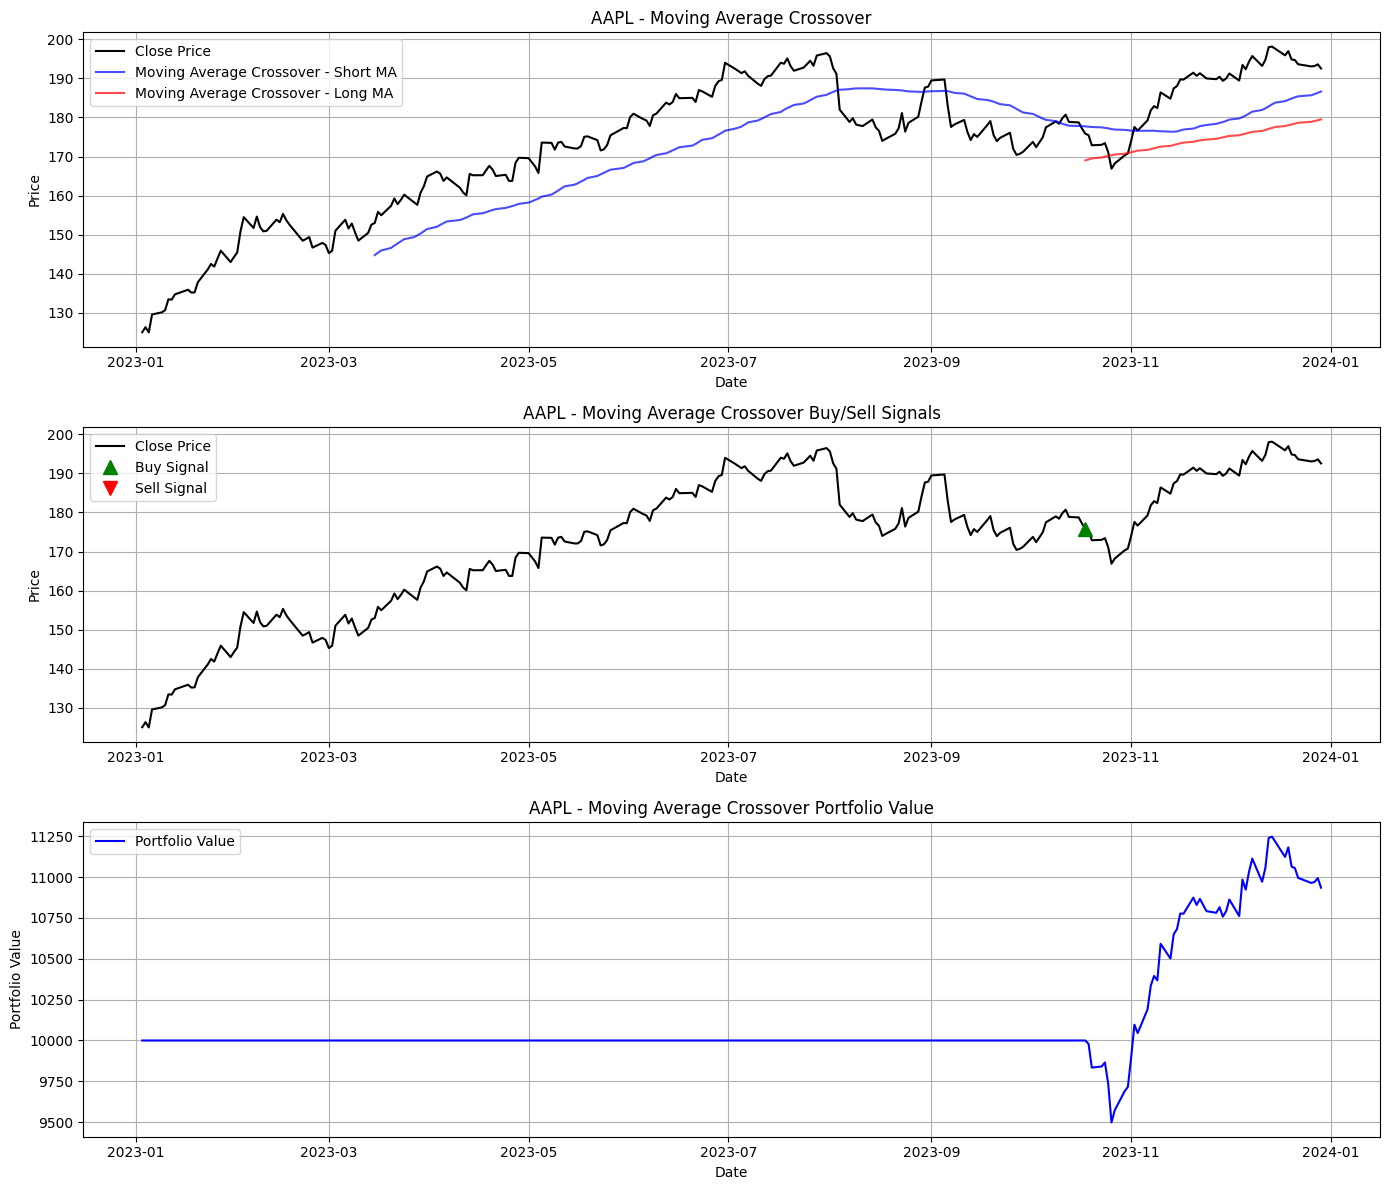

Backtesting RSI...


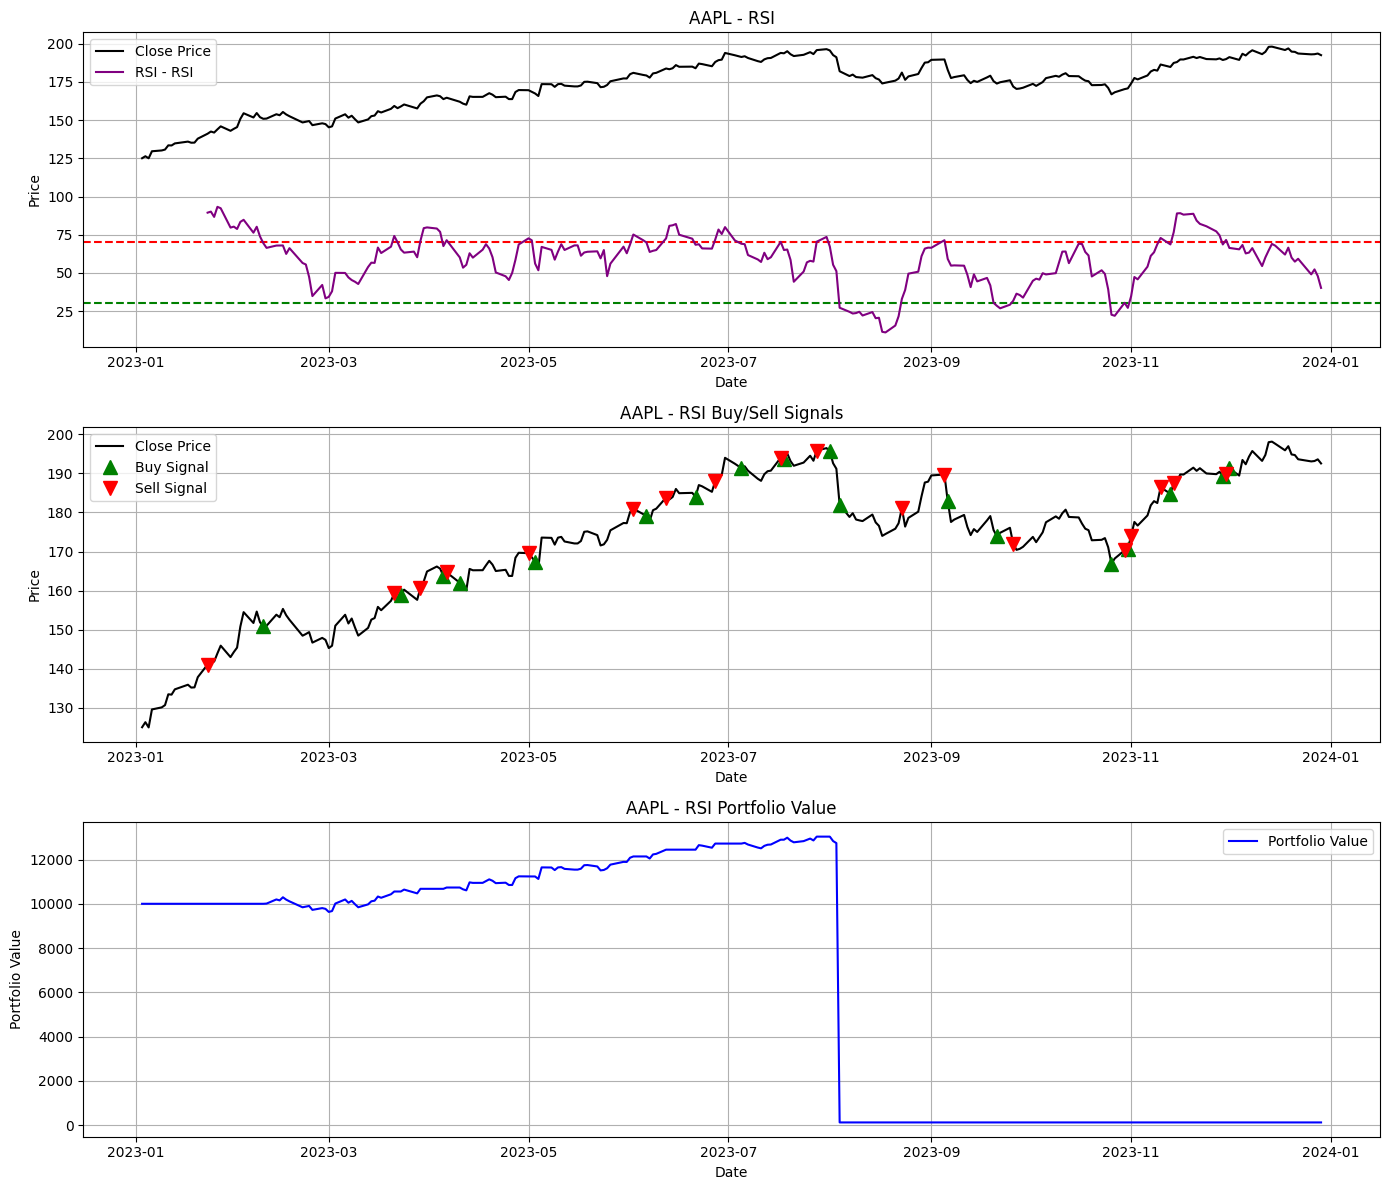

Backtesting Bollinger Bands...


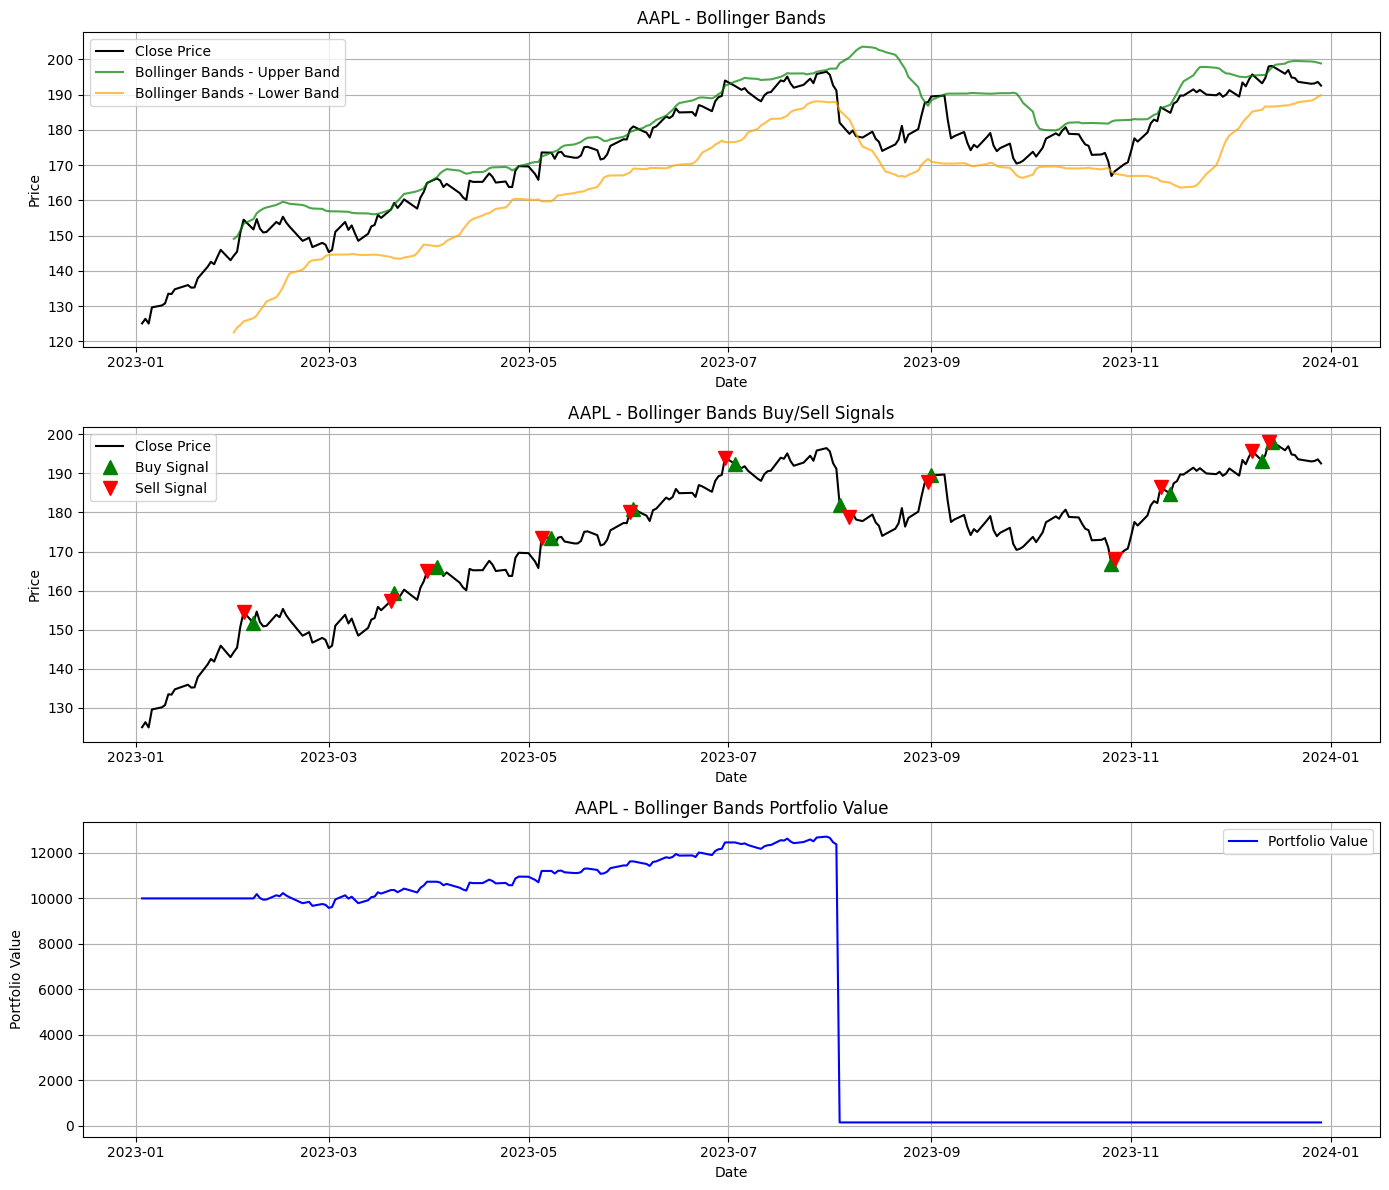

Backtesting MACD...


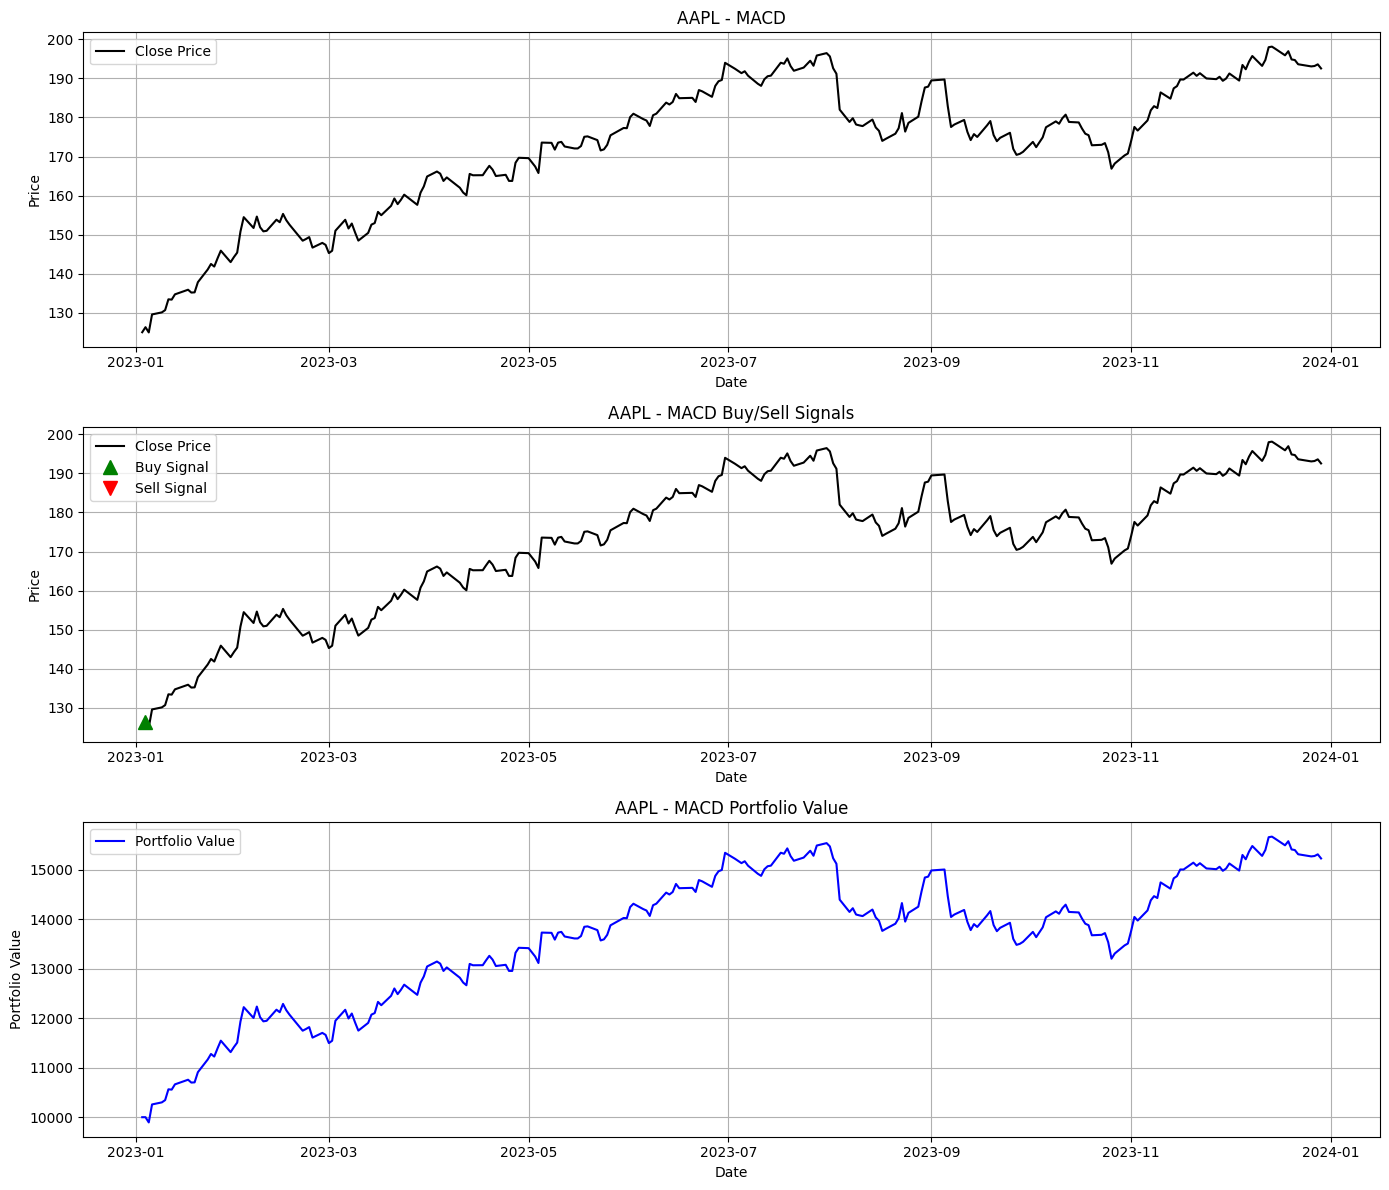

Backtesting EMA Crossover...


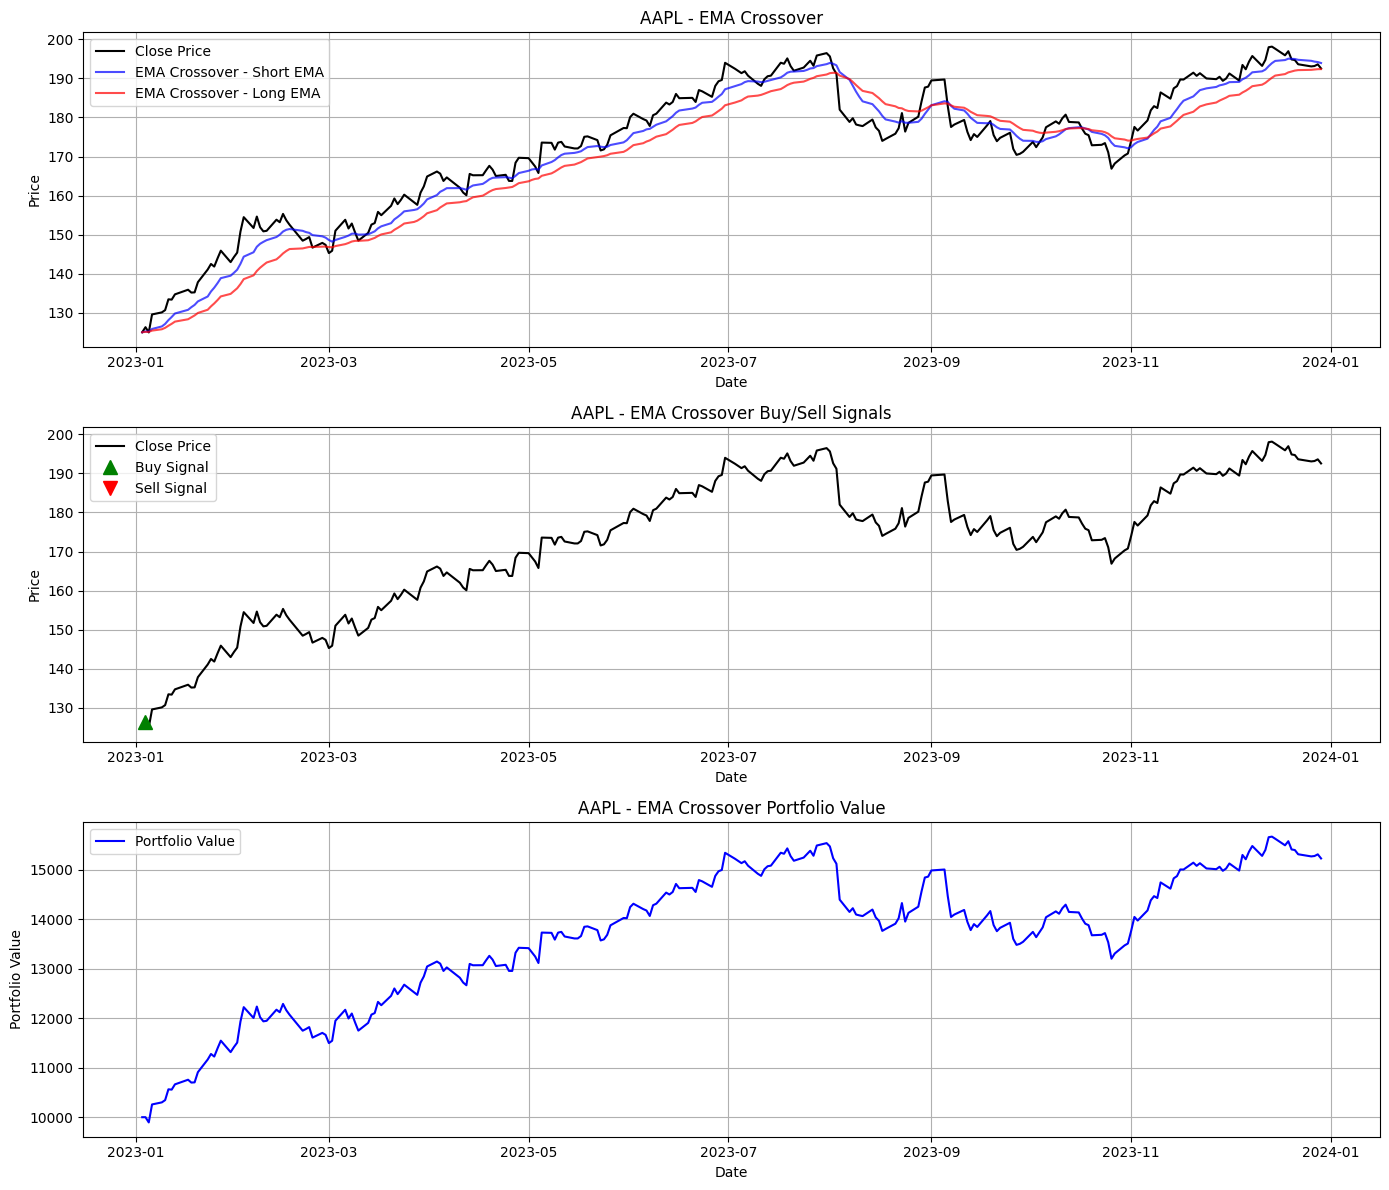

                         Cumulative Returns Annualized Returns Sharpe Ratio  \
Moving Average Crossover           0.093464           0.094246     1.309115   
RSI                               -0.987608          -0.988036    -0.746377   
Bollinger Bands                   -0.985495          -0.985978    -0.772968   
MACD                               0.522743           0.527874     2.239042   
EMA Crossover                      0.522743           0.527874     2.239042   

                         Max Drawdown Calmar Ratio Sortino Ratio  \
Moving Average Crossover     -0.05012     1.880406      1.035814   
RSI                         -0.990493    -0.997519     -0.307679   
Bollinger Bands             -0.988595    -0.997353     -0.372668   
MACD                        -0.150301     3.512119      3.635432   
EMA Crossover               -0.150301     3.512119      3.635432   

                                                                 YoY Growth  
Moving Average Crossover  Year
2023   

In [16]:
ticker = 'AAPL'
start_date = '2023-01-01'
end_date = '2024-01-01'

compare_strategies(ticker, start_date, end_date)
